Описание переменных:

    Зависимая переменная:
    burnout: выгорание на работе.

    Независимые переменные:
    loc: ощущаемый контроль (чем больше значение, тем меньше ощущение контроля над ситуацией)
    
    cope: способность справляться со сложностями (чем больше значение, тем меньше способность)

    teaching: стресс от преподавания (чем выше значение, тем выше уровень стресса)

    research: стресс от проведения исследований (чем выше значение, тем выше уровень стресса)

    pastoral: стресс от бескорыстной помощи коллегам и студентам (чем выше значение, тем выше уровень стресса)

    gender: пол (мужской, женский)

    degree: наличие ученой степени (phd – кандидат наук, mba - мастер делового администрирования, ms – магистр)

Метрические переменные измерены по шкале от 0 до 100

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats 
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from sklearn.metrics import roc_curve, auc
import warnings
warnings.filterwarnings('ignore')

/tmp/ipykernel_215425/3253664417.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [4]:
df = pd.read_excel('/media/daria/Windows/Users/daria/Downloads/burnout.xlsx')
df.head()

,burnout,loc,cope,teaching,research,pastoral,gender,degree
0,Burnt Out,61.764706,81.679389,94.545455,81.250000,96.296296,male,mba
1,Burnt Out,42.941176,39.694656,94.545455,60.416667,87.037037,male,mba
2,Burnt Out,22.352941,17.557252,63.636364,64.583333,68.518519,male,mba
3,Burnt Out,13.529412,25.190840,60.000000,62.500000,66.666667,male,mba
4,Burnt Out,38.235294,34.351145,61.818182,68.750000,61.111111,male,mba


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 467 entries, 0 to 466
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   burnout   467 non-null    object 
 1   loc       467 non-null    float64
 2   cope      467 non-null    float64
 3   teaching  467 non-null    float64
 4   research  467 non-null    float64
 5   pastoral  467 non-null    float64
 6   gender    467 non-null    object 
 7   degree    467 non-null    object 
dtypes: float64(5), object(3)
memory usage: 29.3+ KB


Как мы видим, в нашем датасете нет пропущенных значений, что не требует дополнительной работы с ним.

In [15]:
# Названия переменных, сгруппированные по типам данных
for t in df.dtypes.unique():
     print('Type: {}\n{}\n'.format(t, df.dtypes[df.dtypes==t].index.values))

Type: object
['burnout' 'gender' 'degree']

Type: float64
['loc' 'cope' 'teaching' 'research' 'pastoral']



Соответственно, из переменных gender и degree нужно будет сделать dummie-переменные, а переменную burnout перевести в буль, для использования бинарной регрессии

In [5]:
df['burnout'].value_counts()

burnout
Not Burnt Out    348
Burnt Out        119
Name: count, dtype: int64

По полученному количеству значений мы видим, что группы являются наполненными, и такую переменную можно использовать в качестве зависимой переменной

Зададим наличие выгорания как единицу, а отсуствие выгорания как ноль.

In [6]:
map_dict = {'Burnt Out' : 1,
            'Not Burnt Out' : 0}
 
df['burnout'] = df['burnout'].map(map_dict)

Создадим дамми-переменные для degree и gender

In [7]:
degree_dummies = pd.get_dummies(df["degree"], prefix='degree', prefix_sep='_', dtype=int)
gender_dummies = pd.get_dummies(df["gender"], prefix='gender', prefix_sep='_', dtype=int)

Добавим дамми-переменные в наш датасет

In [8]:
df = pd.concat([df, degree_dummies, gender_dummies], axis=1) 
df

,burnout,loc,cope,teaching,research,pastoral,gender,degree,degree_mba,degree_ms,degree_phd,gender_female,gender_male
0,1,61.764706,81.679389,94.545455,81.250000,96.296296,male,mba,1,0,0,0,1
1,1,42.941176,39.694656,94.545455,60.416667,87.037037,male,mba,1,0,0,0,1
2,1,22.352941,17.557252,63.636364,64.583333,68.518519,male,mba,1,0,0,0,1
3,1,13.529412,25.190840,60.000000,62.500000,66.666667,male,mba,1,0,0,0,1
4,1,38.235294,34.351145,61.818182,68.750000,61.111111,male,mba,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
462,0,7.647059,17.557252,45.454545,47.916667,33.333333,female,phd,0,0,1,1,0
463,0,6.470588,10.687023,27.272727,56.250000,31.481481,female,phd,0,0,1,1,0
464,0,55.882353,24.427481,69.090909,64.583333,29.629630,female,phd,0,0,1,1,0
465,0,7.647059,13.740458,34.545455,79.166667,24.074074,female,phd,0,0,1,1,0


In [6]:
df.columns

Index(['burnout', 'loc', 'cope', 'teaching', 'research', 'pastoral', 'gender',
       'degree', 'degree_mba', 'degree_ms', 'degree_phd', 'gender_female',
       'gender_male'],
      dtype='object')

<Axes: xlabel='burnout'>

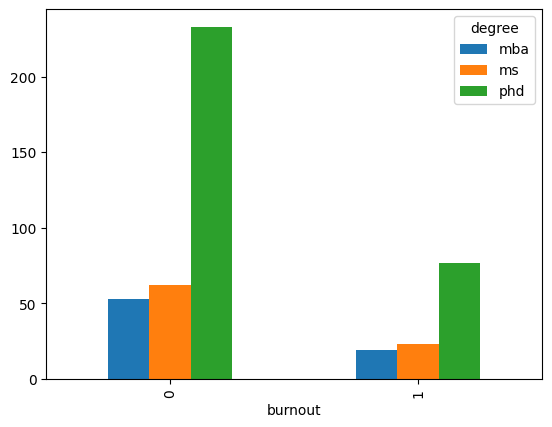

In [9]:
ct = pd.crosstab(df["burnout"], df["degree"])
ct.plot.bar()

### <b> Столбиковая диаграмма burnout-degree показывает распределение выгорания (burnout) в зависимости от ученой степени (degree): MBA, MS, и PhD </b>
#### На данной диаграмме мы видим, что в каждой группе есть представленность из каждого класса, а значит переменную degree можно добавить в качестве предиктора (Если бы у нас были значения только бы из одного класса, тогда не было бы смысла выбираеть ее предиктором, так как модель однозначно определяла бы результат по этому классу). 
#### Также мы видим, что в выборке больше всего людей имеют степень образования PhD, и среди них наблюдается значительное количество тех, у кого нет выгорания (значение 0). Также среди обладателей PhD наблюдается наибольшее количество случаев выгорания (значение 1), что может указывать на некоторую "предрасположенность к выгоранию" в этой группе.


<Axes: xlabel='burnout'>

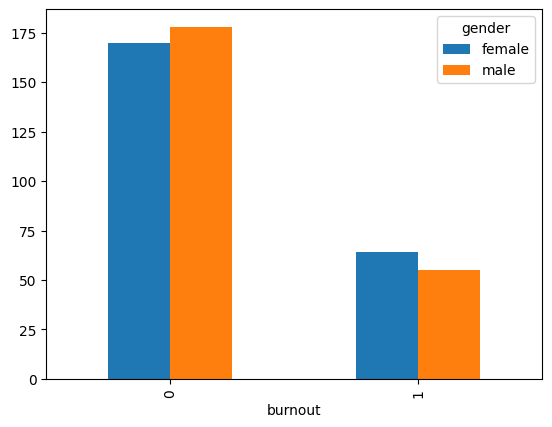

In [10]:
ct = pd.crosstab(df["burnout"], df["gender"])
ct.plot.bar()

### <b> Столбиковая диаграмма burnout-gender показывает распределение выгорания (burnout) среди мужчин и женщин </b>
#### На данной диаграмме мы видим, что в каждой группе есть представленность из каждого класса, а значит переменную gender можно добавить в качестве предиктора (Если бы у нас были значения только бы из одного класса, тогда не было бы смысла выбираеть ее предиктором, так как модель однозначно определяла бы результат по этому классу). 
#### Так же мы видим, что среди и мужчин и женщи больше представителей без выгорания (burnout 0).
#### Также можно обратить внимание на количество записей в каждой группе. Разница в количестве случаев выгорания между мужчинами и женщинами небольшая, но среди женщин их чуть больше. Учитывая близкие пропорции, пол может не быть значимым предиктором для прогнозирования выгорания.

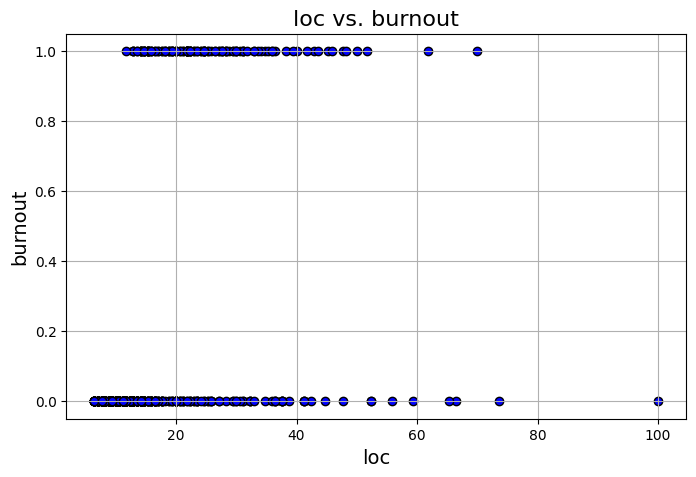

In [11]:
plt.figure(figsize=(8,5))
plt.title('loc vs. burnout', fontsize=16)
plt.scatter(x=df["loc"], y=df["burnout"], color='blue',edgecolor='k')
plt.grid(True)
plt.xlabel("loc", fontsize=14)
plt.ylabel('burnout', fontsize=14)
plt.show()

### <b> Точечная диаграмма loc-burnout показывает распределение выгорания и ощущаемого котроля </b>
#### По данной диаграмме можно сказать, что прямой взамосвязи между переменной loc и burnout не наблюдается. Так как burnout является бинарной переменной, можно было предположить, что при увеличении значений loc вероятность выгорания будет меняться, однако на графике четкой тенденции не видно.
#### Стоит отметить, что основное сосредоточение значений loc находится в диапазоне от 0 до 40, при этом у выгорания наблюдаются как значения 0, так и 1.

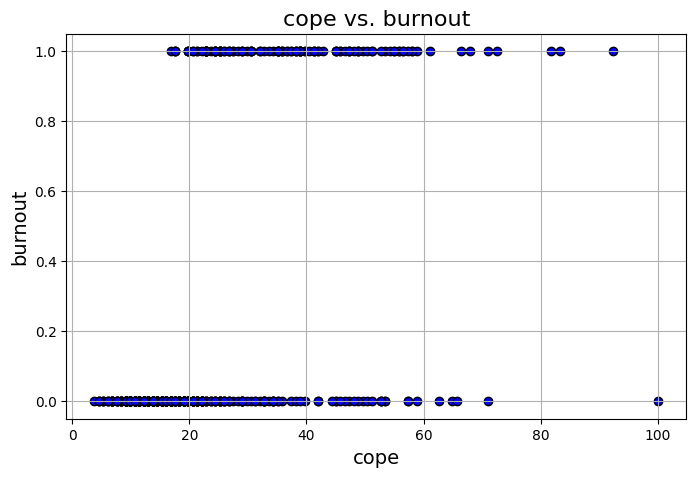

In [12]:
plt.figure(figsize=(8,5))
plt.title('cope vs. burnout', fontsize=16)
plt.scatter(x=df["cope"], y=df["burnout"], color='blue',edgecolor='k')
plt.grid(True)
plt.xlabel("cope", fontsize=14)
plt.ylabel('burnout', fontsize=14)
plt.show()

### <b> Точечная диаграмма cope-burnout показывает распределение выгорания и способности справляться со сложностями </b>
#### По данной диаграмме можно сказать, что прямой взамосвязи между переменной cope и burnout не наблюдается. Так как burnout является бинарной переменной, можно было предположить, что при увеличении значений cope вероятность выгорания будет меняться, однако на графике четкой тенденции не видно.
#### Стоит отметить, что основное сосредоточение значений cope находится в диапазоне от 0 до 60, при этом у выгорания наблюдаются как значения 0, так и 1.

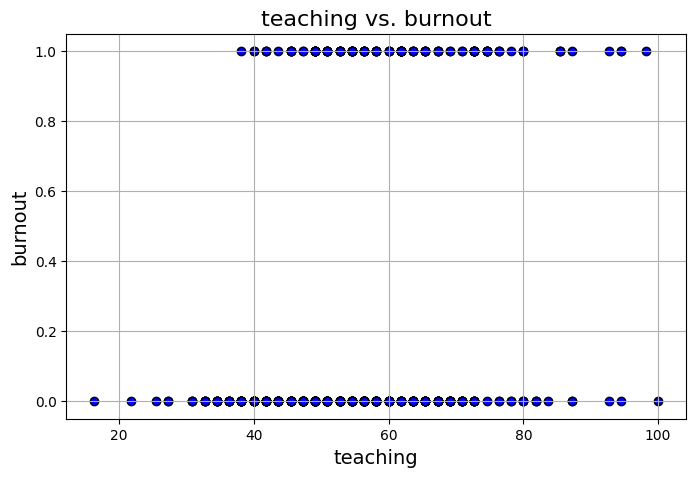

In [13]:
plt.figure(figsize=(8,5))
plt.title('teaching vs. burnout', fontsize=16)
plt.scatter(x=df["teaching"], y=df["burnout"], color='blue',edgecolor='k')
plt.grid(True)
plt.xlabel("teaching", fontsize=14)
plt.ylabel('burnout', fontsize=14)
plt.show()

### <b> Точечная диаграмма burnout-teaching показывает распределение выгорания и стресса от преподавания </b>
#### По данной диаграмме можно сказать, что прямой взамосвязи между переменной teaching и burnout не наблюдается. Так как burnout является бинарной переменной, можно было предположить, что при увеличении значений teaching вероятность выгорания будет меняться, однако на графике четкой тенденции не видно.
#### Стоит отметить, что сосредоточения значений teaching в какой-то конкретной области не наблюдается, значения находятся во всем рассматриваемом диапазоне.

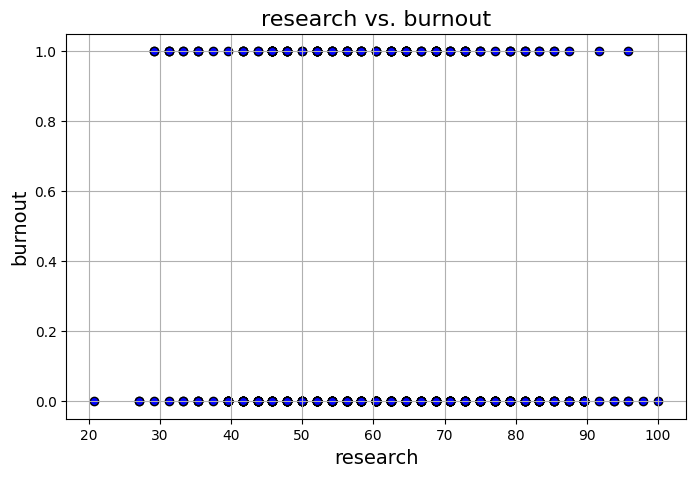

In [14]:
plt.figure(figsize=(8,5))
plt.title('research vs. burnout', fontsize=16)
plt.scatter(x=df["research"], y=df["burnout"], color='blue',edgecolor='k')
plt.grid(True)
plt.xlabel("research", fontsize=14)
plt.ylabel('burnout', fontsize=14)
plt.show()

### <b> Точечная диаграмма burnout-research показывает распределение выгорания и стресса от проведения исследований </b>
#### По данной диаграмме можно сказать, что прямой взамосвязи между переменной research и burnout не наблюдается. Так как burnout является бинарной переменной, можно было предположить, что при увеличении значений research вероятность выгорания будет меняться, однако на графике четкой тенденции не видно.
#### Стоит отметить, что сосредоточения значений research в какой-то конкретной области не наблюдается, значения находятся во всем рассматриваемом диапазоне.

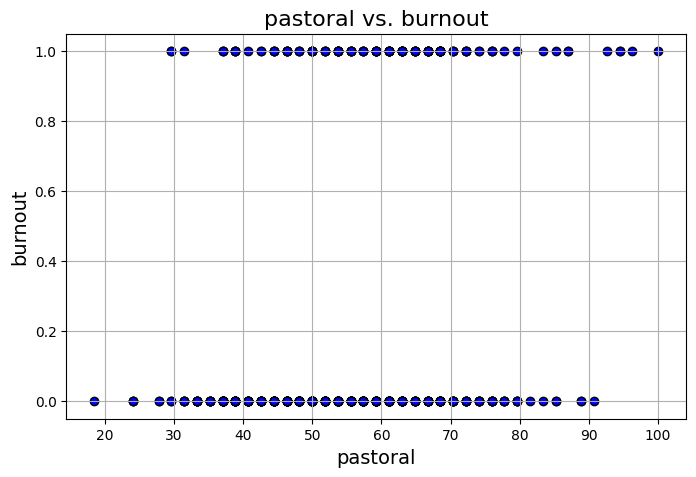

In [15]:
plt.figure(figsize=(8,5))
plt.title('pastoral vs. burnout', fontsize=16)
plt.scatter(x=df["pastoral"], y=df["burnout"], color='blue',edgecolor='k')
plt.grid(True)
plt.xlabel("pastoral", fontsize=14)
plt.ylabel('burnout', fontsize=14)
plt.show()

### <b> Точечная диаграмма burnout-pastoral показывает распределение выгорания и стресса от бескорыстной помощи коллегам и студентам</b>
#### По данной диаграмме можно сказать, что прямой взамосвязи между переменной pastoral и burnout не наблюдается. Так как burnout является бинарной переменной, можно было предположить, что при увеличении значений pastoral вероятность выгорания будет меняться, однако на графике четкой тенденции не видно.
#### Стоит отметить, что сосредоточения значений pastoral в какой-то конкретной области не наблюдается, значения находятся во всем рассматриваемом диапазоне.

### Обобщая выводы по рассмотренным диаграммам можно сказать, что четких визуальных зависимостей между таргетной переменной и предикторами не наблюдается, а значит, можно построить модель, используя все рассмотренные предикторы.

В качестве референтных групп возьмем degree_mba и gender_male

In [9]:
x_mult_with_current_values = df[['loc', 'cope', 'teaching', 'research', 'pastoral', #current
                                 'degree_ms', 'degree_phd', 'gender_female']] #dummie
y_with_current_values = df['burnout']
x_mult_with_current_values_constant = sm.add_constant(x_mult_with_current_values)


### Сформулированные гипотезы исследования:
#### 1) Предиктор loc влияет на наличие выгорания у респондента; 
#### 2) Предиктор cope влияет на наличие выгорания у респондента; 
#### 3) Предиктор teaching влияет на наличие выгорания у респондента; 
#### 4) Предиктор research влияет на наличие выгорания у респондента; 
#### 5) Предиктор pastoral влияет на наличие выгорания у респондента; 
#### 6) Предиктор degree влияет на наличие выгорания у респондента; 
#### 7) Предиктор gender влияет на наличие выгорания у респондента.

In [10]:
model_with_current_values = sm.Logit(y_with_current_values, x_mult_with_current_values_constant).fit()
print(model_with_current_values.summary())

Optimization terminated successfully.
         Current function value: 0.343066
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                burnout   No. Observations:                  467
Model:                          Logit   Df Residuals:                      458
Method:                           MLE   Df Model:                            8
Date:                Tue, 12 Nov 2024   Pseudo R-squ.:                  0.3955
Time:                        21:54:34   Log-Likelihood:                -160.21
converged:                       True   LL-Null:                       -265.05
Covariance Type:            nonrobust   LLR p-value:                 5.805e-41
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -4.7684      1.180     -4.042      0.000      -7.080      -2.456
loc               0.

### <b> Рассмотрим основные метрики полученной модели: </b>

#### Псевдо R-квадрат (0,3955) указывает на объясняющую способность модели. Значение 0,3955 означает, что около 39,55% вариации целевой переменной burnout объясняется предикторами в модели. Это невысокий показатель, но в данном случае он приемлем, так как для бинарной регрессии R-квадрат часто ниже, чем в линейной.

#### Логарифм правдоподобия для модели без предикторов (-265,05). Это правдоподобие "нулевой" модели, в которой нет предикторов, только константа.

#### Сравнив LL и LL-Null можно сказать, что добавление предикторов значительно улучшает модель по сравнению с нулевой моделью.

#### P-value (5,805e-41) указывает на статистическую значимость модели . Такое низкое значение (5,805e-41) говорит о том, что модель значимо лучше, чем нулевая модель, и предикторы действительно влияют на вероятность выгорания. По данному значению можно сказать, что модель статистически значима.

### Интерпритация полученных коэффициентов возможна после примения к ним функции экспоненты. Рассмотрим это далее.

In [11]:
coefs = pd.DataFrame()
coefs['Coefs'] = model_with_current_values.params[1:]
coefs['Features'] = model_with_current_values.params.index[1:]
coefs.set_index('Features', inplace=True)
print('Intercept = ', model_with_current_values.params[0])
coefs['OddsRatio'] = np.exp(coefs.Coefs)
coefs
#коэффициенты регрессии и отношения шансов

Intercept =  -4.768438524278337


,Coefs,OddsRatio
Features,,
loc,0.110665,1.117021
cope,0.141427,1.151916
teaching,-0.111659,0.894349
research,0.019564,1.019757
pastoral,0.046632,1.047737
degree_ms,0.096241,1.101024
degree_phd,0.137884,1.147843
gender_female,0.230101,1.258727


### <b> Выводы по сформулированным гипотезам исследования. </b>
#### Зеленым цветом отмечены гипотезы, которые подтвердились, а красным те, которые не подтвердились (учитывая 5% уровень значимости)
#### <span style='color:Green'> 1) Предиктор loc влияет на наличие выгорания у респондента - Гипотеза подтверждается, так как данная переменная статистически значима; 
#### <span style='color:Green'> 2) Предиктор cope влияет на наличие выгорания у респондента - Гипотеза подтверждается, так как данная переменная статистически значима; 
#### <span style='color:Green'> 3) Предиктор teaching влияет на наличие выгорания у респондента - Гипотеза подтверждается, так как данная переменная статистически значима; 
#### <span style='color:Red'> 4) Предиктор research влияет на наличие выгорания у респондента - Гипотеза НЕ подтверждается, так как данная переменная статистически НЕ значима; 
#### <span style='color:Green'> 5) Предиктор pastoral влияет на наличие выгорания у респондента - Гипотеза подтверждается, так как данная переменная статистически значима; 
#### <span style='color:Red'> 6) Предиктор degree влияет на наличие выгорания у респондента - Гипотеза НЕ подтверждается, так как данная переменная статистически НЕ значима; 
#### <span style='color:Red'> 7) Предиктор gender влияет на наличие выгорания у респондента - Гипотеза НЕ подтверждается, так как данная переменная статистически НЕ значима.

In [13]:
def yes_no(p_value, level = 0.05):
    if abs(p_value) < level:
        return 'significant'
    else:
        return 'non-significant'

In [14]:
pvals = pd.DataFrame()
pvals['p_values'] = model_with_current_values.pvalues[1:]
pvals['5% level']= pvals['p_values'].apply(yes_no)
pvals['p_values'] = pvals['p_values'].map('{:.3f}'.format)
pvals['Features'] = model_with_current_values.params.index[1:]
pvals.set_index('Features',inplace=True)
pvals['10% level'] = model_with_current_values.pvalues[1:].apply(lambda x: yes_no(x, level=0.1))
pvals

,p_values,5% level,10% level
Features,,,
loc,0.000,significant,significant
cope,0.000,significant,significant
teaching,0.000,significant,significant
research,0.061,non-significant,significant
pastoral,0.000,significant,significant
degree_ms,0.844,non-significant,non-significant
degree_phd,0.732,non-significant,non-significant
gender_female,0.433,non-significant,non-significant


#### Как мы видим статистически значимые предикторы на 5% уровне являются: loc, cope, teaching, pastoral. Для 5% уровня статистически не значимымы являются предикторы degree, gender и research.

#### На 10% уровне статистически значимые предикторы немного отличаются от уровня 5% значимости. В данном случае, статистически значимыми предиктораями являются const, loc, cope, teaching, pastoral, research. А статистически не значимымы предикторами являются degree и gender.

### <b> Рассмотрим коэффициенты модели, к которым применена функция экспоненты, и их значимость для интерпретации вероятности выгорания, с учетом 5% значимости: </b>

#### Предикторы degree, gender и research не являются статистически значимыми - нет необходимости их интерпритировать.

#### Предиктор loc (ощущаемый контроль). Значение коэффициента = 1,117021. Положительное значение коэффициента указывает, что, в среднем, с увеличением loc (чем меньше человек ощущает контроль над ситуацией), вероятность выгорания увеличивается на 12%. 

#### Предиктор cope (способность справляться со сложностями). Значение коэффициента = 1,151916. Положительное значение коэффициента указывает на то, что, в среднем, увеличение значения cope (снижение способности справляться со сложностями) на единицу увеличивает вероятность выгорания на 15%. 

#### Предиктор teaching (стресс от преподавания). Значение коэффициента = 0,894349. Значение ниже 1 свидетельсвует о том, что, в среднем, с ростом стресса от преподавания на единицу возможность выгорания снижается на 11%.

#### Предиктор pastoral (стресс от бескорыстной помощи коллегам и студентам). Значение коэффициента = 1,047737. Положительное значение коэффициета говорит о том, что, в среднем, с ростом стресса от бескорыстной помощи коллегам и студентам на единицу, возможность выгорания увеличивается на 4%.

In [15]:
print('R^2 = {:f}'.format(model_with_current_values.prsquared))
print('Model significance = {:f}'.format(model_with_current_values.llr_pvalue))

R^2 = 0.395549
Model significance = 0.000000


Из полученных значений r^2 и p-value можно отметить, что модель статистически значима и объясняет 39% значений зависимой переменной.

In [16]:
l = []
for (param, index) in zip(model_with_current_values.params[1:], model_with_current_values.params.index[1:]):
    l.append('{:.2f}*{}'.format(param, index))
    
print('logit(p) = {:2f} + {}'.format(model_with_current_values.params[0], ' + '.join(l)))

logit(p) = -4.768439 + 0.11*loc + 0.14*cope + -0.11*teaching + 0.02*research + 0.05*pastoral + 0.10*degree_ms + 0.14*degree_phd + 0.23*gender_female


#### Полученная линейная часть уравнение бинарной регрессии:

#### logit(p) = -4.768439 + 0.11\*loc + 0.14\*cope + -0.11\*teaching + 0.02\*research + 0.05\*pastoral + 0.10\*degree_ms + 0.14\*degree_phd + 0.23\*gender_female

### <b> Интерпретация значений коэффициентов регрессии </b>

### Матрица ошибок

In [17]:
cm = model_with_current_values.pred_table()
print('TP: {} | FN: {}\n-------------------\nFP: {}  | TN: {}'.format(cm[0,0], cm[0,1], cm[1,0], cm[1,1]))

TP: 322.0 | FN: 26.0
-------------------
FP: 53.0  | TN: 66.0


### В полученной матрице указаны четыре метрики:

#### TP (True Positives) = 322: Количество истинно положительных случаев — когда модель правильно предсказала наличие выгорания (1).
#### FN (False Negatives) = 26: Количество ложно отрицательных случаев — когда модель ошибочно предсказала отсутствие выгорания (0), хотя в реальности это было наличие выгорания (1).
#### FP (False Positives) = 53: Количество ложно положительных случаев — когда модель оишбочно предсказала наличие выгорания (1), хотя в реальности это было отсутсвие выгорания (0).
#### TN (True Negatives) = 66: Количество истинно отрицательных случаев — когда модель правильно предсказала класс отсутствие выгорания (0).

#### Как мы видим, из 467 наблюдений 388 (322+66) было предсказано моделью верно, а оставшиеся 79 (26 и 53) значения были предсказаны неверно. Большая часть значений предсказывается верно, можно сделать вывод о хорошем качестве модели

In [29]:
accuracy = (cm[0,0] + cm[1,1]) / sum(sum(cm))
print('Точность (доля правильных ответов алгоритма): = {}'.format(accuracy))

Точность (доля правильных ответов алгоритма): = 0.8308351177730193


#### Полученное значение <b> accuracy </b> говорит о том, что модель классифицирует правильно около 83,1% случаев.

In [26]:
recall = cm[0,0] / (cm[0,0] + cm[0,1])
print('Полнота для класса "1" (наличие выгорания): = {}'.format(recall))

Полнота для класса "1" (наличие выгорания): = 0.9252873563218391


####  <b> recall </b> - это то, какую долю объектов положительного класса из всех объектов положительного класса нашёл алгоритм.Полученное значение recall 92,5% говорит о том, что модель хорошо находит большинство положительных случаев.

Ссылка на источник [https://habr.com/ru/articles/661119/]

In [30]:
precision = cm[0,0] / (cm[0,0] + cm[1,0])
print('Точность для класса "1" (наличие выгорания): = {}'.format(precision))    

Точность для класса "1" (наличие выгорания): = 0.8586666666666667


#### <b> precision </b> - это доля объектов, названными моделью положительными и при этом действительно являющимися положительными, в нашем случае составяет 86%.

Ссылка на источник [https://habr.com/ru/articles/661119/]

#### В целом, у модели наблюдается хороший баланс между полнотой и точностью, что делает ее эффективной для определения выгорания по выбранным критериям.

### ROC-curve

In [19]:
fpr, tpr, _ = roc_curve(df["burnout"], model_with_current_values.predict())
roc_auc = auc(fpr, tpr)

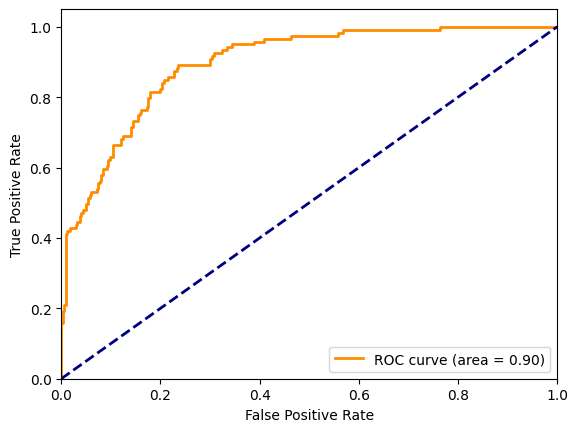

In [20]:
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

#### ROC-кривая показывает, насколько хорошо модель справляется с разделением классов (в нашем случае наличие или отсуствие выгорания).

#### Каждая точка на графике соответствует выбору некоторого порога. Площадь под кривой показывает качество алгоритма (больше — лучше), кроме этого, важной является крутизна самой кривой — мы хотим максимизировать TPR, минимизируя FPR, а значит, наша кривая в идеале должна стремиться к точке (0,1).

#### Ссылка на источник [https://habr.com/ru/companies/ods/articles/328372/]

#### ROC-кривая имеет площадь под кривой (AUC) равную 0,90, что, в целом, говорит о хорошем качестве модели. Чем ближе AUC к 1, тем лучше модель справляется с определением наличия или отсуствия выгорания - кривая находится значительно выше диагонали, что указывает на то, что модель не случайно угадывает значения, а определяет их (с хорошей точностью) на основании выявленных зависимостей.

# Диагностика модели

### Остатки

In [ ]:
p = stats.kstest(model_with_current_values.resid_generalized, 'norm', args=(model_with_current_values.resid_generalized.mean(), model_with_current_values.resid_generalized.std())).pvalue
print('P-value: {:.3f}'.format(p))

P-value: 0.000


<Axes: ylabel='Density'>

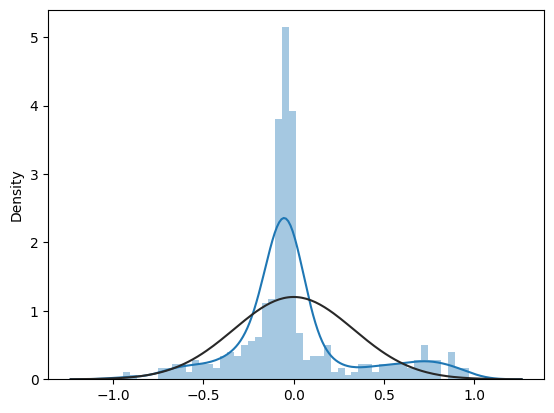

In [22]:
sns.distplot(model_with_current_values.resid_generalized, fit=stats.norm) 

### <b> По графику распределения остатков видно следующее: </b>
#### Преимущественно остатки находятся в районе нуля, что указывает на то, что модель в среднем не имеет смещения и предсказывает зависимую переменную burnout без систематической ошибки. 

#### Форма распределения осотаков визуально близка к нормальному распределению, хотя имеется пик в центре, что может указывать на небольшую концентрацию остатков вокруг нуля. 

#### На графике не видно явной асимметрии или значительных выбросов.

### <b> Мультиколлинеарность </b>

In [ ]:
vifs = np.array([vif(model_with_current_values.model.exog, i) for i in range(model_with_current_values.model.exog.shape[1])])

In [ ]:
vif_df = pd.DataFrame()
vif_df['VIF'] = vifs[1:]
vif_df['Features'] = model_with_current_values.params.index[1:]
vif_df.sort_values(by=['VIF'])

,VIF,Features
7,1.037647,gender_female
3,1.094108,research
0,1.266576,loc
4,1.397120,pastoral
1,1.790338,cope
5,1.812869,degree_ms
6,1.819401,degree_phd
2,2.294505,teaching


Нет значений VIF, превышающих 10. Проблема мультиколлинеарности отсутствует.

### Сохранение предсказанной вероятности наступления события для каждого наблюдения

In [24]:
df['probability'] = model_with_current_values.predict()
df.sort_values('probability')

,burnout,loc,cope,teaching,research,pastoral,gender,degree,degree_mba,degree_ms,degree_phd,gender_female,gender_male,probability
215,0,12.352941,10.687023,49.090909,56.250000,18.518519,male,ms,0,1,0,0,1,0.004912
291,0,10.588235,11.450382,56.363636,35.416667,50.000000,male,phd,0,0,1,0,1,0.006009
208,0,37.647059,5.343511,72.727273,29.166667,48.148148,male,ms,0,1,0,0,1,0.006337
204,0,31.176471,5.343511,69.090909,41.666667,53.703704,male,ms,0,1,0,0,1,0.007680
313,0,7.647059,12.213740,49.090909,35.416667,42.592593,male,phd,0,0,1,0,1,0.007696
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,1,32.941176,67.938931,65.454545,41.666667,79.629630,female,phd,0,0,1,1,0,0.997702
42,1,31.176471,92.366412,92.727273,45.833333,100.000000,male,phd,0,0,1,0,1,0.999166
7,1,31.176471,83.206107,74.545455,35.416667,87.037037,female,mba,1,0,0,1,0,0.999182
33,1,70.000000,58.015267,76.363636,64.583333,94.444444,female,ms,0,1,0,1,0,0.999825


### По полученным значениям предсказанной вероятности (probability) получения выгорания можно сказать следующее:

#### Если у человека (по статистически значимым показателям - loc, cope, teaching, pastoral) loc (ощущаемый контроль) ≈ 61,76, cope (способность справляться со сложностями) ≈ 81,68, teaching (стресс от преподавания) ≈ 94,55, pastoral (стресс от бескорыстной помощи коллегам и студентам) ≈ 96,30, то у него <b> наивысшая вероятность наличия выгорания (0.99989). </b>

#### Если у человека (по статистически значимым показателям - loc, cope, teaching, pastoral) loc (ощущаемый контроль) ≈ 12,35, cope (способность справляться со сложностями) ≈ 10,69, teaching (стресс от преподавания) ≈ 49,09, pastoral (стресс от бескорыстной помощи коллегам и студентам) ≈ 18,52, то у него <b> наименьшая вероятность наличия выгорания (0,0049). </b>

### <b> Выводы </b>

#### Для построения модели бинарной регрессии, которая определяет наличие (или отсуствие) выгорания у человека, были выбраны <b> метрические предикторы </b> (которые измерены по шкале от 0 до 100): loc (ощущаемый контроль), cope (способность справляться со сложностями), teaching (стресс от преподавания), research (стресс от проведения исследований), pastoral (стресс от бескорыстной помощи коллегам и студентам), а также <b> категорильные предикторы </b>: gender (пол - мужской, женский) и degree (наличие ученой степени: phd – кандидат наук, mba - мастер делового администрирования, ms – магистр).

#### После построения модели было выявлено, что среди выбранных предикторов, <b> значимыми являются переменные loc, cope, teaching, и pastoral </b>. Увеличение loc, cope и pastoral повышает вероятность выгорания, в то время как teaching снижает ее. Оставшиеся <b> предикторы (research, degree и gende) являются статистически не значимыми. </b>

#### Полученное значение accuracy говорит о том, что модель классифицирует правильно около 83,1% случаев. Полученное значение recall 92,5% говорит о том, что модель хорошо находит большинство положительных случаев. Precision (доля объектов, названными моделью положительными и при этом действительно являющимися положительными) составяет 86%.

#### ROC-кривая имеет площадь под кривой (AUC) равную 0,90, что, в целом, говорит о хорошем качестве модели. Кривая находится значительно выше диагонали, что указывает на то, что модель не случайно угадывает значения, а определяет их (с хорошей точностью) на основании выявленных зависимостей.

#### Распределение остатов модели похоже на нормальное, явных выбросов не заметно.

#### Проблема мультиколлениарности в данной модели отсуствует.

#### В целом, можно отметить, что полученная модель бинарной регрессии хорошо справляется с поставленной задачей и является статистически значимой.

#### <b> Среди неожиданных для нас результатов стало следующее: </b>
#### - Обратное влияние teaching на наличие выгорания. Мы предполагали, что рост стресса от преподавания приводит к увеличению получения выгорания, но получили обратные результат;
#### - Статистически не значимый предиктор "gender". Мы предполагали, что выгоранию чаще подвергаются женщины (что связано с наличием семейных проблем, ответственности за детей, и других бытовых проблем).
#### Отсуствие же связи выгорания с наличием ученой степени мы предполагали изначально (т.к. люди, получающие любую ученую степень, сразу понимают куда и зачем идут, и, скорее всего, готовы к тем сложностям, с которыми им придется столкнуться)